Technological Institute of the Philippines | Quezon City - Computer Engineering
--- | ---
Course Code: | CPE 313
Course Title: | Advanced Machine Learning and Deep Learning
2nd Semester | AY 2024-2025
<u>**ACTIVITY NO.** | Assignment 4.1 Mood Detection with OpenCV
**Name** | Base, Angelo P.
**Section** | CPE32S1
**Date Performed**: | 06/04/2025
**Date Submitted**: | 13/04/2025
**Instructor**: | Dr. Alonica Villanueva
<hr>

In [2]:
import os
import cv2
import numpy as np

import pickle
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import itertools

from deepface import DeepFace
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

### Face Recognition

In [ ]:
dataset_path = "custom_facial_expression_dataset/train"
my_face_folders = ["angry", "happy", "sad", "confused"]
others_folder = "custom_facial_expression_dataset/others"

embeddings = []
labels = []

# Process my_face_folders images
for folder in my_face_folders:
  folder_path = os.path.join(dataset_path, folder)
  for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    try:
      embedding = DeepFace.represent(img_path, model_name="Facenet")[0]["embedding"]
      embeddings.append(embedding)
      labels.append(1)
    except:
      print(f"Skipping image: {img_path}")

# Process others images
for img_name in os.listdir(others_folder):
  img_path = os.path.join(others_folder, img_name)
  try:
    embedding = DeepFace.represent(img_path, model_name="Facenet")[0]["embedding"]
    embeddings.append(embedding)
    labels.append(0)
  except:
    print(f"Skipping image: {img_path}")

embeddings = np.array(embeddings)
labels = np.array(labels)

with open("pkl/face_embeddings.pkl", "wb") as f:
  pickle.dump((embeddings, labels), f)
print("Saved!")

Skipping image: custom_facial_expression_dataset/train\angry\Training_10.jpg
Skipping image: custom_facial_expression_dataset/train\angry\Training_110.jpg
Skipping image: custom_facial_expression_dataset/train\angry\Training_116.jpg
Skipping image: custom_facial_expression_dataset/train\angry\Training_117.jpg
Skipping image: custom_facial_expression_dataset/train\angry\Training_119.jpg
Skipping image: custom_facial_expression_dataset/train\angry\Training_12.jpg
Skipping image: custom_facial_expression_dataset/train\angry\Training_120.jpg
Skipping image: custom_facial_expression_dataset/train\angry\Training_121.jpg
Skipping image: custom_facial_expression_dataset/train\angry\Training_137.jpg
Skipping image: custom_facial_expression_dataset/train\angry\Training_14.jpg
Skipping image: custom_facial_expression_dataset/train\angry\Training_142.jpg
Skipping image: custom_facial_expression_dataset/train\angry\Training_157.jpg
Skipping image: custom_facial_expression_dataset/train\angry\Traini

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Face Recognition Accuracy: {accuracy * 100:.2f}%")

with open("pkl/face_recognition_model.pkl", "wb") as f:
  pickle.dump(svm_model, f)
print("Saved!")

Face Recognition Accuracy: 98.14%
Saved!


## Mood Detection

### Load Dataset

In [8]:
TRAIN_DIR = ('custom_facial_expression_dataset/train/')
TEST_DIR = ('custom_facial_expression_dataset/test/')
VAL_DIR = ('custom_facial_expression_dataset/validation/')

In [9]:
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

IMG_SIZE = 48

In [10]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, (IMG_SIZE, IMG_SIZE))
X_test, y_test, test_labels = load_data(TEST_DIR, (IMG_SIZE, IMG_SIZE))
X_val, y_val, val_labels = load_data(VAL_DIR, (IMG_SIZE, IMG_SIZE))

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:26<00:00,  6.72s/it]


800 images loaded from custom_facial_expression_dataset/train/ directory.


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


120 images loaded from custom_facial_expression_dataset/test/ directory.


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

120 images loaded from custom_facial_expression_dataset/validation/ directory.


In [11]:
train_labels

{0: 'angry', 1: 'confused', 2: 'happy', 3: 'sad'}

In [12]:
test_labels

{0: 'angry', 1: 'confused', 2: 'happy', 3: 'sad'}

In [13]:
val_labels

{0: 'angry', 1: 'confused', 2: 'happy', 3: 'sad'}

In [14]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_train.shape

(800, 4)

In [15]:

y_test = to_categorical(y_test, num_classes=4)
y_test.shape

(120, 4)

In [16]:
y_val = to_categorical(y_val, num_classes=4)
y_val.shape

(120, 4)

### Creating Model

In [122]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

for layer in conv_base.layers[:15]:
    layer.trainable = False

for layer in conv_base.layers[15:]:
    layer.trainable = True

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [123]:
model = Sequential([
    conv_base,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_13 (Flatten)        (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 14,979,396
Trainable params: 7,344,132
Non-trainable params: 7,635,264
_________________________________________________________________


### Data Augmentation

In [124]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

### Train Model

In [125]:
EPOCHS = 50
BATCH_SIZE = 64

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data = (X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/50
13/13 [==============================] - 2s 126ms/step - loss: 1.4976 - accuracy: 0.2587 - val_loss: 1.3841 - val_accuracy: 0.2917
Epoch 2/50
13/13 [==============================] - 1s 51ms/step - loss: 1.4240 - accuracy: 0.2912 - val_loss: 1.3688 - val_accuracy: 0.3250
Epoch 3/50
13/13 [==============================] - 1s 52ms/step - loss: 1.3925 - accuracy: 0.3075 - val_loss: 1.3546 - val_accuracy: 0.3750
Epoch 4/50
13/13 [==============================] - 1s 52ms/step - loss: 1.3382 - accuracy: 0.3600 - val_loss: 1.3328 - val_accuracy: 0.4500
Epoch 5/50
13/13 [==============================] - 1s 50ms/step - loss: 1.3354 - accuracy: 0.3562 - val_loss: 1.3178 - val_accuracy: 0.4417
Epoch 6/50
13/13 [==============================] - 1s 52ms/step - loss: 1.2568 - accuracy: 0.4175 - val_loss: 1.2867 - val_accuracy: 0.4333
Epoch 7/50
13/13 [==============================] - 1s 54ms/step - loss: 1.2503 - accuracy: 0.4375 - val_loss: 1.2783 - val_accuracy: 0.4250
Epoch 8/50
1

## Evaluation and Testing

In [128]:
model.save('model/new_dataset/new_dataset_mood_classification_vgg16_5.h5')

In [ ]:
# Save the history to compare with other model
# with open("pkl/new_dataset/new_dataset_mood_classification_vgg16_5.pkl", "wb") as f:
#     pickle.dump(history.history, f)

In [3]:
model = load_model('model/new_dataset/new_dataset_mood_classification_vgg16_5.h5')

In [4]:
# Load the history
with open("pkl/new_dataset/new_dataset_mood_classification_vgg16_5.pkl", "rb") as f:
    history = pickle.load(f)

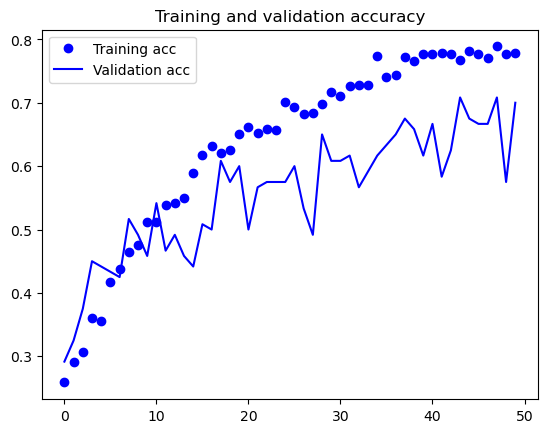

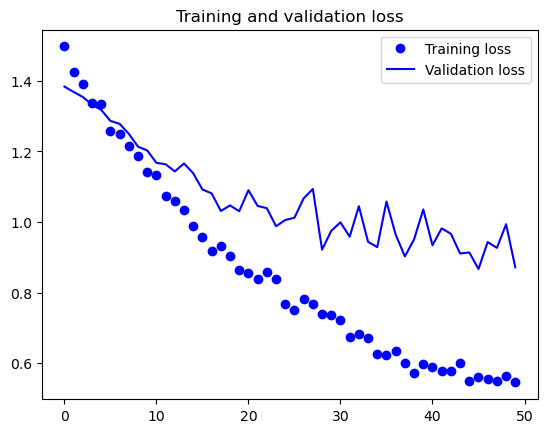

In [5]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

4/4 [==============================] - 40s 2s/step
Test Accuracy = 0.59


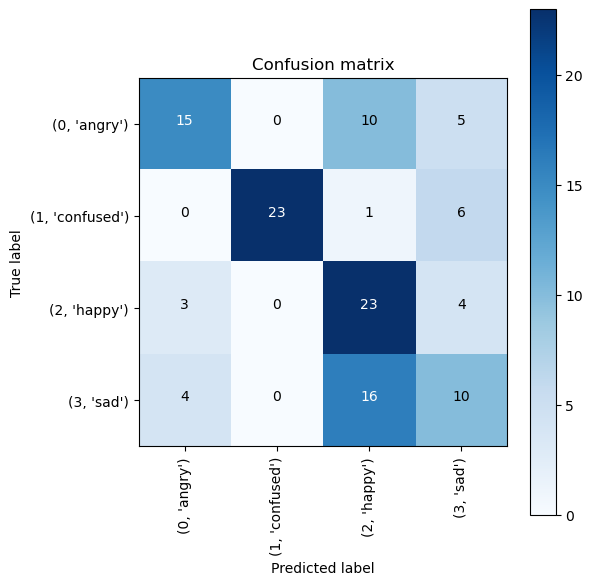

In [17]:
predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]

y_test_class_indices = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test_class_indices, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test_class_indices, y_pred) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.items()), normalize=False)

In [ ]:
with open("pkl/face_recognition_model.pkl", "rb") as f:
    face_recognizer = pickle.load(f)
with open("pkl/face_embeddings.pkl", "rb") as f:
    embeddings_data = pickle.load(f)
embeddings, labels = embeddings_data

mood_model = load_model("model/mood_classification_vgg16.h5")

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

emotion_labels = ["angry", "happy", "sad", "confused"]

webcam_capture = cv2.VideoCapture(0)

while True:
    ret, frame = webcam_capture.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        face = frame[y: y+h, x: x+w]

        label_text = "Unknown"

        try:
            embedding = DeepFace.represent(face, model_name="Facenet", enforce_detection=False)[0]["embedding"]
            probs = face_recognizer.predict_proba([embedding])[0]
            pred_label = face_recognizer.predict([embedding])[0]
            face_conf = probs[1] if pred_label == 1 else probs[0]
        
            if pred_label == 1:
                try:
                    face_resized = cv2.resize(face, (48, 48))
                    face_array = img_to_array(face_resized) / 255.0
                    face_array = np.expand_dims(face_array, axis=0)

                    prediction = mood_model.predict(face_array, verbose=0)[0]
                    emotion = emotion_labels[np.argmax(prediction)]
                    emotion_conf = np.max(prediction)

                    label_text = f"{emotion} ({emotion_conf*100:.1f}%)"
                except:
                    label_text = "(Error)"
            
            else:
                label_text = f"Unknown ({face_conf*100:.1f}%)"
        
        except:
            label_text = "Recognition Error"
            
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, label_text, (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    
    cv2.imshow("Face Recognition & Mood Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

webcam_capture.release()
cv2.destroyAllWindows()